<a href="https://colab.research.google.com/github/sokdnv/project_1/blob/main/IIC_ResNet50_08_05_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фаза 2 • Неделя 8 • Пятница
## Нейронные сети
### Распознавание Intel Image Classification на ResNet50

In [2]:
!pip -qq install torchutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.9 MB/s eta 0:00:00


In [20]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import os

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## Fine Tuning

Теперь обучим модель под свою задачу – сделаем **fine-tuning**. Возьмем `resnet18` для скорости – он намного меньше.

In [7]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(DEVICE)

fake_batch = torch.randn(1, 3, 150, 150, device=DEVICE)
tu.get_model_summary(model, fake_batch)


Layer                                         Kernel              Output          Params          FLOPs
0_conv1                                      [3, 64, 7, 7]     [1, 64, 75, 75]       9,408   52,920,000
1_bn1                                                 [64]     [1, 64, 75, 75]         128    1,440,000
2_relu                                                   -     [1, 64, 75, 75]           0            0
3_maxpool                                                -     [1, 64, 38, 38]           0            0
4_layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [1, 64, 38, 38]       4,096    5,914,624
5_layer1.0.BatchNorm2d_bn1                            [64]     [1, 64, 38, 38]         128      369,664
6_layer1.0.ReLU_relu                                     -     [1, 64, 38, 38]           0            0
7_layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [1, 64, 38, 38]      36,864   53,231,616
8_layer1.0.BatchNorm2d_bn2                            [64]     [

In [14]:
# Создаем класс модели нейронки на основе ResNet50

class MyResNet50(nn.Module):
    def __init__(self):
        super().__init__()

        # подгружаем базовую модель ResNet50
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        # заменяем выходной слой - на выходе 6 классов
        self.model.fc = nn.Linear(2048, 6)
        # замораживаем все слои
        for i in self.model.parameters():
            i.requires_grad = False
        # размораживаем последний слой - для обучения
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)


model = MyResNet50()
model.to(DEVICE);

In [18]:
# Просмотр сруктуры модели
model

MyResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [17]:
# Проверка настроек последнего слоя
model.model.fc

Linear(in_features=2048, out_features=6, bias=True)

In [21]:
# Распаковываем архив
zip_path = 'iic_archive.zip'
extract_to = './data/'
os.makedirs(extract_to, exist_ok=True)

!unzip -q {zip_path} -d {extract_to}

In [24]:
# Делаем трансформации, которые подразумевает модель:
# она обучалась на изображениях такого формата
train_transforms = T.Compose([
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=.5),
    T.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5),
    T.Resize((150, 150)),  # Изменение размера изображений
    T.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    T.ToTensor(),  # Конвертация изображений в тензоры
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])

# Преобразования для валидационных данных
valid_transforms = T.Compose([
    T.Resize((150, 150)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [25]:
# Про ImageFolder
# читаем тут: https://elbrus-ds-cheatsheets.streamlit.app/PyTorch_Datasets
import torchvision
train_dataset = torchvision.datasets.ImageFolder(
    'data/seg_train/seg_train',
    transform=train_transforms
)
valid_dataset = torchvision.datasets.ImageFolder(
    'data/seg_test/seg_test',
    transform=valid_transforms
)

In [26]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: data/seg_train/seg_train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-180.0, 180.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [27]:
train_dataset.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [28]:
# Словарь для определения класса по индексу
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.BCEWithLogitsLoss()

In [35]:
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(3):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images).squeeze(-1)
        print(preds, preds.shape)
        print(labels, labels.shape)

        loss = criterion(preds, labels.float())
        loss_batch.append(loss.item())
        accuracy = (preds.sigmoid().round() == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            preds = model(images).squeeze(-1)


        loss = criterion(preds, labels.float())
        loss_batch.append(loss.item())

        accuracy = (preds.sigmoid().round() == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'\t  metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')

tensor([[ 0.0412, -0.0527,  0.2175,  0.2332, -0.0960, -0.0050],
        [ 0.2558, -0.0198, -0.0133,  0.1634, -0.2508,  0.2051],
        [-0.0257,  0.1284,  0.1721, -0.0467,  0.0629, -0.2735],
        [ 0.0744,  0.2117, -0.1455,  0.2356,  0.0332,  0.0095],
        [ 0.0418, -0.1319,  0.0693,  0.0456,  0.1335, -0.1451],
        [ 0.0786,  0.2681,  0.0907,  0.2252,  0.1831,  0.0761],
        [ 0.0974, -0.2328,  0.3087, -0.0845, -0.2078,  0.0113],
        [-0.0225,  0.1126,  0.0255, -0.0302,  0.1348,  0.1762],
        [-0.0022,  0.0781,  0.2040,  0.2529,  0.1509, -0.0690],
        [-0.0723,  0.1619,  0.0174,  0.1453,  0.0167, -0.0586],
        [ 0.2280,  0.0988,  0.0210,  0.0439, -0.2075, -0.2030],
        [-0.2339, -0.0842,  0.2526,  0.2044, -0.1325, -0.0985],
        [-0.2766, -0.0674,  0.3173,  0.0132,  0.1342, -0.1213],
        [-0.0360, -0.0996, -0.1465,  0.2164, -0.0683,  0.1640],
        [-0.0830,  0.2173,  0.3345, -0.0540,  0.1701,  0.2867],
        [ 0.0500,  0.0462, -0.2643,  0.0

ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 6]))

In [ ]:
model

MyResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
idx2class

{0: 'cats', 1: 'dogs'}

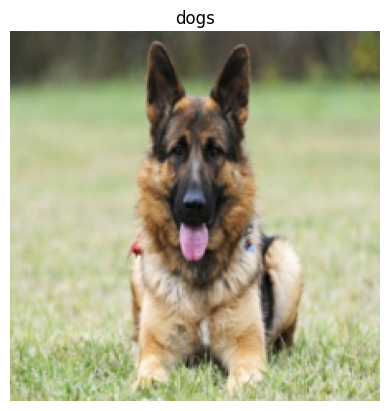

In [ ]:
img = resize(io.read_image('image.jpg')/255)
plt.imshow(torch.permute(img, (1, 2, 0)))
with torch.inference_mode():
    pred_class = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE))).round().item()
plt.axis('off')
plt.title(idx2class[pred_class]);

## Unfreezing example

Теперь возьмем MobileNet (эта модель разрабатывалась специально для мобильных устройств – можно почитать про неё тут: https://telegra.ph/MobileNet-v1-v3-11-24)

In [ ]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
mob_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 28.3MB/s]


In [ ]:
# Смотрим архитектуру модели, чтобы узнать названия слоев
mob_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# Добираемся до последнего слоя
mob_model.classifier[3] = nn.Linear(1024, 1)

In [ ]:
mob_model

In [ ]:
# Замораживаем все, чтобы разморозить только нужное
for p in mob_model.parameters():
    p.requires_grad = False

In [ ]:
# Unfreeze head layer
## classifier -> (0) Linear
mob_model.classifier[0].weight.requires_grad = True
mob_model.classifier[0].bias.requires_grad = True
## classifier -> (3) Linear
mob_model.classifier[3].weight.requires_grad = True
mob_model.classifier[3].bias.requires_grad = True

# Unfreeze last features layer
## features -> (0) Conv2d
mob_model.features[12][0].weight.requires_grad = True
mob_model.features[12][1].weight.requires_grad = True
mob_model.features[12][1].bias.requires_grad = True

In [ ]:
for param in mob_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True


In [ ]:
for p in list(mob_model.parameters())[-10:]:
    print(p.requires_grad)

## Saving and Loading models

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_1 = nn.Linear(33, 1)
        self.fc_2 = nn.Linear(33, 2)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.fc_2(out)
        return out

In [ ]:
model = Model()

In [ ]:
# fit
# eval
# test

In [ ]:
model.state_dict()

OrderedDict([('fc_1.weight',
              tensor([[ 0.0227,  0.1136, -0.0866,  0.0430,  0.0083, -0.1334,  0.1403,  0.1227,
                       -0.0929,  0.0042, -0.1311,  0.0808, -0.0992, -0.1009, -0.0477, -0.0237,
                       -0.0250,  0.1005, -0.0146, -0.1253, -0.0449,  0.1402,  0.0257,  0.0096,
                       -0.1062, -0.0928,  0.0714, -0.1473,  0.1518,  0.1081,  0.1480,  0.1619,
                       -0.1129]])),
             ('fc_1.bias', tensor([0.0803])),
             ('fc_2.weight',
              tensor([[-0.1323,  0.0147, -0.0850, -0.0103, -0.0205,  0.1216, -0.1073,  0.1660,
                       -0.1730,  0.0032,  0.1019,  0.1479, -0.0664,  0.1189,  0.0306,  0.1615,
                        0.1403,  0.0437,  0.1213,  0.1699,  0.0656,  0.0407, -0.1497,  0.0773,
                        0.1435, -0.1050, -0.0976, -0.1487,  0.0012, -0.0013, -0.0105,  0.0534,
                       -0.1547],
                      [-0.1573, -0.0901,  0.1206, -0.0951, -0.0844,

In [ ]:
torch.save(model.state_dict(), 'weights.pt')

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_1 = nn.Linear(32, 1)
        self.fc_2 = nn.Linear(33, 2)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.fc_2(out)
        return out

model = Model()

In [ ]:
model.load_state_dict(torch.load('weights.pt'))

RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for fc_1.weight: copying a param with shape torch.Size([1, 33]) from checkpoint, the shape in current model is torch.Size([1, 32]).

In [ ]:
model.state_dict()

OrderedDict([('fc_1.weight',
              tensor([[ 0.0227,  0.1136, -0.0866,  0.0430,  0.0083, -0.1334,  0.1403,  0.1227,
                       -0.0929,  0.0042, -0.1311,  0.0808, -0.0992, -0.1009, -0.0477, -0.0237,
                       -0.0250,  0.1005, -0.0146, -0.1253, -0.0449,  0.1402,  0.0257,  0.0096,
                       -0.1062, -0.0928,  0.0714, -0.1473,  0.1518,  0.1081,  0.1480,  0.1619,
                       -0.1129]])),
             ('fc_1.bias', tensor([0.0803])),
             ('fc_2.weight',
              tensor([[-0.1323,  0.0147, -0.0850, -0.0103, -0.0205,  0.1216, -0.1073,  0.1660,
                       -0.1730,  0.0032,  0.1019,  0.1479, -0.0664,  0.1189,  0.0306,  0.1615,
                        0.1403,  0.0437,  0.1213,  0.1699,  0.0656,  0.0407, -0.1497,  0.0773,
                        0.1435, -0.1050, -0.0976, -0.1487,  0.0012, -0.0013, -0.0105,  0.0534,
                       -0.1547],
                      [-0.1573, -0.0901,  0.1206, -0.0951, -0.0844,

In [ ]:
def preprocess_model():
    mob_model = mobilenet_v3_small()
    mob_model.classifier[3] = nn.Linear(1024, 1)
    mob_model.load_state_dict(...)
    mob_model.eval()
    return mob_model